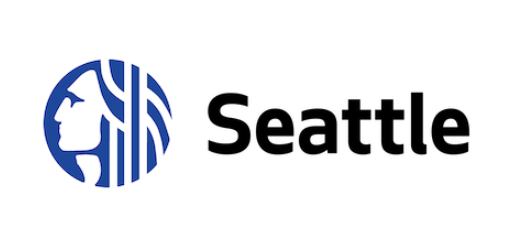

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', 80)

In [2]:
pip install xgboost

# Contexte
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.



# Objectifs
Vous cherchez également à évaluer l’intérêt de l’**ENERGY STAR Score** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

In [3]:
df = pd.read_csv('Building_Benchmarking.csv') 

In [4]:
df_log = pd.read_csv('Building_Log_Benchmarking.csv') 

Head() pour afficher les 5 premières lignes du dataframe `df`.

In [5]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,47.612190,-122.337997,1927,1.0,12.0,88434,0.0,88434.0,Hotel,Hotel,NaN,NaN,65.0,78.9,173.5,6981428.0,2023032.0,3686160.0,1272388.0,249.43,100.00,0.00,0.00
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,47.613106,-122.333358,1996,1.0,11.0,103566,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,51.0,94.4,191.3,8354235.0,0.0,3905411.0,4448985.0,263.51,80.99,14.55,4.46
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,47.613349,-122.337699,1969,1.0,41.0,961990,0.0,961990.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,18.0,96.6,242.7,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,78.72,10.40,0.00
3,5,2015,NonResidential,Hotel,HOTEL MAX,47.614216,-122.336609,1926,1.0,10.0,61320,0.0,61320.0,Hotel,Hotel,NaN,NaN,1.0,460.4,636.3,28229320.0,23458518.0,2769023.0,2001894.0,1936.34,100.00,0.00,0.00
4,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),47.616439,-122.336764,1999,1.0,2.0,97288,37198.0,60090.0,Police Station,Police Station,NaN,NaN,NaN,135.7,313.5,12051984.0,0.0,7271004.0,4781283.0,304.62,91.31,0.00,0.00


la taille du dataframe avec shape

In [6]:
df.shape

(2674, 28)

min, max, moyenne, écart type, etc) pour toutes les variables quantitatives avec describes

In [7]:
df.describe()

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA
count,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2.674000e+03,2674.000000,2.674000e+03,1786.000000,2674.000000,2674.000000,2.674000e+03,2.674000e+03,2.674000e+03,2.674000e+03,2674.000000,2674.000000,2674.000000,2674.000000
mean,15453.525804,2015.512341,47.614603,-122.333696,1960.838818,1.114435,4.254675,1.184212e+05,14939.116679,1.034821e+05,64.709966,71.807530,178.210135,7.785679e+06,4.035296e+05,5.683280e+06,1.658018e+06,158.824570,82.248280,13.386945,2.135636
std,13154.516387,0.499941,0.046718,0.024022,32.955544,2.375913,6.492263,2.682347e+05,46765.031227,2.497738e+05,28.472265,74.093515,188.132233,2.454841e+07,4.330989e+06,1.816080e+07,5.853002e+06,549.857837,20.126535,21.167726,6.351193
min,1.000000,2015.000000,47.499170,-122.411820,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,1.000000,0.200000,0.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.080000,18.350000,0.000000,0.000000
25%,572.000000,2015.000000,47.585030,-122.343201,1929.000000,1.000000,1.000000,2.901975e+04,0.000000,2.812600e+04,48.000000,33.100000,77.400000,1.180530e+06,0.000000e+00,7.005642e+05,0.000000e+00,19.202500,66.235000,0.000000,0.000000
50%,20986.000000,2016.000000,47.611655,-122.333354,1965.000000,1.000000,2.000000,4.881950e+04,0.000000,4.664500e+04,72.000000,51.750000,132.600002,2.456574e+06,0.000000e+00,1.596202e+06,4.220580e+05,47.150000,90.860000,1.950000,0.000000
75%,24374.000000,2016.000000,47.645885,-122.322899,1988.000000,1.000000,4.000000,1.068600e+05,0.000000,9.530650e+04,88.000000,81.400001,205.200001,6.785792e+06,0.000000e+00,4.855296e+06,1.329851e+06,133.670000,100.000000,24.932500,0.000000
max,50226.000000,2016.000000,47.733870,-122.258640,2015.000000,111.000000,76.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,1.381912e+08,12307.160000,100.000000,630.150000,150.940000


In [8]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'pourcentage_LargestPropertyUseTypeGFA',
       'pourcentage_SecondLargestPropertyUseTypeGFA',
       'pourcentage_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [9]:
for col in df.columns:
    print(f'{col :-<70} {df[col].nunique()}')

OSEBuildingID--------------------------------------------------------- 1409
DataYear-------------------------------------------------------------- 2
BuildingType---------------------------------------------------------- 4
PrimaryPropertyType--------------------------------------------------- 25
PropertyName---------------------------------------------------------- 2578
Latitude-------------------------------------------------------------- 2510
Longitude------------------------------------------------------------- 2430
YearBuilt------------------------------------------------------------- 113
NumberofBuildings----------------------------------------------------- 14
NumberofFloors-------------------------------------------------------- 43
PropertyGFATotal------------------------------------------------------ 1385
PropertyGFAParking---------------------------------------------------- 319
PropertyGFABuilding(s)------------------------------------------------ 1398
ListOfAllPropertyUseTypes-

In [10]:
#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OSEBuildingID                                2674 non-null   int64  
 1   DataYear                                     2674 non-null   int64  
 2   BuildingType                                 2674 non-null   object 
 3   PrimaryPropertyType                          2674 non-null   object 
 4   PropertyName                                 2674 non-null   object 
 5   Latitude                                     2674 non-null   float64
 6   Longitude                                    2674 non-null   float64
 7   YearBuilt                                    2674 non-null   int64  
 8   NumberofBuildings                            2674 non-null   float64
 9   NumberofFloors                               2674 non-null   float64
 10  

# Feature Engineering

## Build Age

In [11]:
df['Build_Age'] = df['DataYear'] - df['YearBuilt']

In [12]:
df['Build_Age'].max()

116

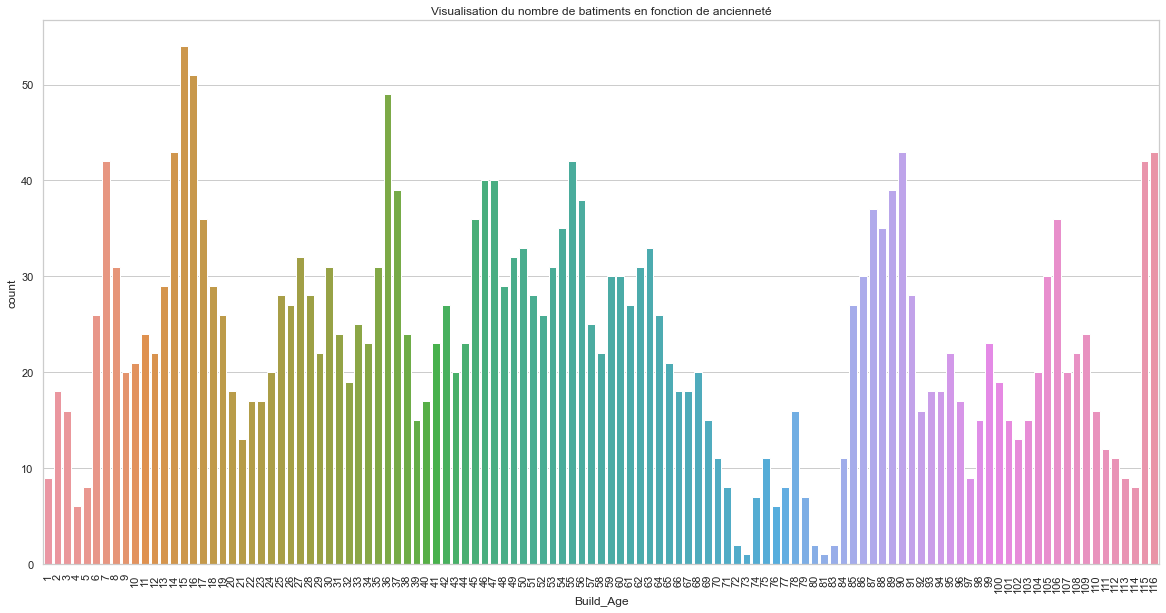

In [13]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.set_style('whitegrid')
sns.countplot(x='Build_Age', data=df).set(title='Visualisation du nombre de batiments en fonction de ancienneté')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [14]:
df.drop(['OSEBuildingID', 'DataYear','YearBuilt'], axis=1, inplace=True)

## Surface Nb de Building

In [15]:
df = df.assign(surface_nb_building=lambda x: round( x['PropertyGFATotal'] / x['NumberofBuildings'], 2))

In [16]:
df.drop(['NumberofBuildings'], axis=1, inplace=True)

## Energy
Nous calculons le poucentage de chaque energy ('SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu) en fonction de l'énergy total use

In [17]:
df = df.assign(pourcentage_Electricity=lambda x: round( x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [18]:
df = df.assign(pourcentage_NaturalGas=lambda x: round( x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [19]:
df = df.assign(pourcentage_SteamUse=lambda x: round( x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)']*100, 2))

In [20]:
df[[ 'pourcentage_Electricity', 'pourcentage_NaturalGas', 'pourcentage_SteamUse']]

,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse
0,52.80,18.23,28.98
1,46.75,53.25,0.00
2,68.05,5.07,26.88
3,9.81,7.09,83.10
4,60.33,39.67,0.00
...,...,...,...
2669,61.70,38.30,0.00
2670,41.73,58.27,0.00
2671,31.08,68.92,0.00
2672,48.49,51.51,0.00


In [21]:
df.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'], axis=1, inplace=True)

## Localisation batiment - Geopandas

In [22]:
import geopandas as gpd
from shapely.geometry import Point

In [23]:
# Create a geometry column by constructing Point objects from the lon and lat columns
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [24]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [25]:
gdf.crs

In [26]:
gdf = gdf[gdf.is_valid == True]

<AxesSubplot:>

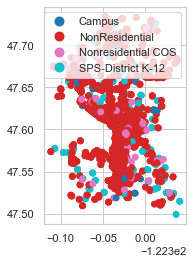

In [27]:
gdf['geometry'].centroid
gdf.plot(column = "BuildingType",legend=True)

Suite à notre feature engineering, nous vous rajouter ces nouvelles features à notre dataset df_log

Nous supprimons maintenant les features qui nous semblent moins pertinentes pour la suite de notre analyse

# Encodage

In [28]:
df.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(30)


occurring_cat = [cat for cat in df.LargestPropertyUseType.value_counts().sort_values(ascending = False).head(40).index]


for cat in occurring_cat:
    df[cat] = np.where((df['LargestPropertyUseType'] == cat)|
                           (df['SecondLargestPropertyUseType'] == cat)|
                           (df['ThirdLargestPropertyUseType'] == cat), 1, 0) 

## GFA Property encode
### Assign log_pourcentage_LargestPropertyUseTypeGFA

In [29]:
# colonne pour la surface GFA log_pourcentage_LargestPropertyUseTypeGFA
gfa_col = 'pourcentage_LargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'LargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df.loc[mask, feature] = df.loc[mask, gfa_col]

### Assign log_pourcentage_SecondLargestPropertyUseTypeGFA

In [30]:
# colonne pour la surface GFA log_pourcentage_SecondLargestPropertyUseTypeGFA
gfa_col = 'pourcentage_SecondLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col = 'SecondLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df.loc[mask, feature] = df.loc[mask, gfa_col]

### Assign log_pourcentage_ThirdLargestPropertyUseTypeGFA

In [31]:
# colonne pour la surface GFA log_pourcentage_ThirdLargestPropertyUseTypeGFA
gfa_col ='pourcentage_ThirdLargestPropertyUseTypeGFA'

# colonne pour le type de propriété
property_col ='ThirdLargestPropertyUseType'

# liste des colonnes features
features_cols = ['Small- and Mid-Sized Office', 'Warehouse',
                 'K-12 School', 'Other', 'Retail Store', 'Hotel', 'Worship Facility',
                 'Distribution Center', 'Medical Office', 'Supermarket / Grocery Store',
                 'Self-Storage Facility', 'Other - Recreation', 'Parking',
                 'Other - Entertainment/Public Assembly', 'University', 'Restaurant',
                 'Refrigerated Warehouse', 'Social/Meeting Hall', 'Laboratory',
                 'Manufacturing/Industrial Plant', 'Automobile Dealership',
                 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Museum',
                 'Hospital (General Medical & Surgical)', 'Library', 'Other - Services',
                 'Bank Branch', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall',
                 'Other - Education', 'Fitness Center/Health Club/Gym',
                 'Financial Office', 'Other/Specialty Hospital', 'Strip Mall',
                 'Performing Arts', 'Data Center', 'Pre-school/Daycare',
                 'Adult Education', 'Other - Restaurant/Bar', 'Prison/Incarceration']

# Boucle pour chaque feature
for feature in features_cols:
    # Selection des lignes ou la feature de type de propriété est égale à la feature en cours de traitement
    mask = df[property_col] == feature
    # Assignation de la valeur de la colonne gfa_col à la colonne feature en cours de traitement
    df.loc[mask, feature] = df.loc[mask, gfa_col]

In [32]:
df

,BuildingType,PrimaryPropertyType,PropertyName,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,pourcentage_LargestPropertyUseTypeGFA,pourcentage_SecondLargestPropertyUseTypeGFA,pourcentage_ThirdLargestPropertyUseTypeGFA,Build_Age,surface_nb_building,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse,geometry,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Library,Urgent Care/Clinic/Other Outpatient,Hospital (General Medical & Surgical),Bank Branch,Other - Services,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other - Education,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Adult Education,Pre-school/Daycare,Prison/Incarceration
0,NonResidential,Hotel,MAYFLOWER PARK HOTEL,47.612190,-122.337997,12.0,88434,0.0,88434.0,Hotel,Hotel,NaN,NaN,65.0,78.900000,173.500000,6.981428e+06,249.43,100.00,0.00,0.00,88,88434.0,52.80,18.23,28.98,POINT (-122.33800 47.61219),0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,NonResidential,Hotel,PARAMOUNT HOTEL,47.613106,-122.333358,11.0,103566,15064.0,88502.0,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,51.0,94.400000,191.300000,8.354235e+06,263.51,80.99,14.55,4.46,19,103566.0,46.75,53.25,0.00,POINT (-122.33336 47.61311),0.0,0.0,0.0,0.0,0.0,80.99,0.0,0.0,0.0,0.0,0.0,0.00,14.55,0.0,0.0,4.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,NonResidential,Hotel,WESTIN HOTEL,47.613349,-122.337699,41.0,961990,0.0,961990.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,18.0,96.600000,242.700000,7.313066e+07,2061.48,78.72,10.40,0.00,46,961990.0,68.05,5.07,26.88,POINT (-122.33770 47.61335),0.0,0.0,0.0,0.0,0.0,78.72,0.0,0.0,0.0,0.0,0.0,0.00,10.40,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,NonResidential,Hotel,HOTEL MAX,47.614216,-122.336609,10.0,61320,0.0,61320.0,Hotel,Hotel,NaN,NaN,1.0,460.400000,636.300000,2.822932e+07,1936.34,100.00,0.00,0.00,89,61320.0,9.81,7.09,83.10,POINT (-122.33661 47.61422),0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),47.616439,-122.336764,2.0,97288,37198.0,60090.0,Police Station,Police Station,NaN,NaN,NaN,135.700000,313.500000,1.205198e+07,304.62,91.31,0.00,0.00,16,97288.0,60.33,39.67,0.00,POINT (-122.33676 47.61644),0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,Nonresidential COS,Office,Horticulture building,47.567220,-122.311540,1.0,12294,0.0,12294.0,Office,Small- and Mid-Sized Office,NaN,NaN,46.0,69.099998,161.699997,8.497457e+05,20.94,100.00,0.00,0.00,26,12294.0,61.70,38.30,0.00,POINT (-122.31154 47.56722),100.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0

In [33]:
# drop feature
df.drop(['LargestPropertyUseType','BuildingType','PropertyName',
               'SecondLargestPropertyUseType', 'geometry',
               'ThirdLargestPropertyUseType','ListOfAllPropertyUseTypes',
               'pourcentage_LargestPropertyUseTypeGFA','PrimaryPropertyType',
               'pourcentage_SecondLargestPropertyUseTypeGFA',
               'pourcentage_ThirdLargestPropertyUseTypeGFA'], axis=1, inplace=True)

In [34]:
df

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,Build_Age,surface_nb_building,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Library,Urgent Care/Clinic/Other Outpatient,Hospital (General Medical & Surgical),Bank Branch,Other - Services,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other - Education,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Adult Education,Pre-school/Daycare,Prison/Incarceration
0,47.612190,-122.337997,12.0,88434,0.0,88434.0,65.0,78.900000,173.500000,6.981428e+06,249.43,88,88434.0,52.80,18.23,28.98,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,47.613106,-122.333358,11.0,103566,15064.0,88502.0,51.0,94.400000,191.300000,8.354235e+06,263.51,19,103566.0,46.75,53.25,0.00,0.0,0.0,0.0,0.0,0.0,80.99,0.0,0.0,0.0,0.0,0.0,0.00,14.55,0.0,0.0,4.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,47.613349,-122.337699,41.0,961990,0.0,961990.0,18.0,96.600000,242.700000,7.313066e+07,2061.48,46,961990.0,68.05,5.07,26.88,0.0,0.0,0.0,0.0,0.0,78.72,0.0,0.0,0.0,0.0,0.0,0.00,10.40,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,47.614216,-122.336609,10.0,61320,0.0,61320.0,1.0,460.400000,636.300000,2.822932e+07,1936.34,89,61320.0,9.81,7.09,83.10,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,47.616439,-122.336764,2.0,97288,37198.0,60090.0,NaN,135.700000,313.500000,1.205198e+07,304.62,16,97288.0,60.33,39.67,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,47.567220,-122.311540,1.0,12294,0.0,12294.0,46.0,69.099998,161.699997,8.497457e+05,20.94,26,12294.0,61.70,38.30,0.00,100.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2670,47.596250,-122.322830,1.0,16000,0.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,32.17,12,16000.0,41.73,58.27,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2671,47.636440,-122.357840,1.0,13157,0.0,13157.0,NaN,438.200012,744.799988,5.765898e+06,223.54,42,13157.0,31.08,68.92,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,57.63,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2672,47.528320,-122.324310,1.0,14101,0.0,14101.0,NaN,51.000000,105.300003,7.194712e+05,22.11,27,14101.0,48.49,51.51,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,46.81,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.43,0.0


# Target Feature

In [35]:
df

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,Build_Age,surface_nb_building,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Library,Urgent Care/Clinic/Other Outpatient,Hospital (General Medical & Surgical),Bank Branch,Other - Services,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other - Education,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Adult Education,Pre-school/Daycare,Prison/Incarceration
0,47.612190,-122.337997,12.0,88434,0.0,88434.0,65.0,78.900000,173.500000,6.981428e+06,249.43,88,88434.0,52.80,18.23,28.98,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,47.613106,-122.333358,11.0,103566,15064.0,88502.0,51.0,94.400000,191.300000,8.354235e+06,263.51,19,103566.0,46.75,53.25,0.00,0.0,0.0,0.0,0.0,0.0,80.99,0.0,0.0,0.0,0.0,0.0,0.00,14.55,0.0,0.0,4.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,47.613349,-122.337699,41.0,961990,0.0,961990.0,18.0,96.600000,242.700000,7.313066e+07,2061.48,46,961990.0,68.05,5.07,26.88,0.0,0.0,0.0,0.0,0.0,78.72,0.0,0.0,0.0,0.0,0.0,0.00,10.40,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,47.614216,-122.336609,10.0,61320,0.0,61320.0,1.0,460.400000,636.300000,2.822932e+07,1936.34,89,61320.0,9.81,7.09,83.10,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,47.616439,-122.336764,2.0,97288,37198.0,60090.0,NaN,135.700000,313.500000,1.205198e+07,304.62,16,97288.0,60.33,39.67,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,47.567220,-122.311540,1.0,12294,0.0,12294.0,46.0,69.099998,161.699997,8.497457e+05,20.94,26,12294.0,61.70,38.30,0.00,100.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2670,47.596250,-122.322830,1.0,16000,0.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,32.17,12,16000.0,41.73,58.27,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2671,47.636440,-122.357840,1.0,13157,0.0,13157.0,NaN,438.200012,744.799988,5.765898e+06,223.54,42,13157.0,31.08,68.92,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,57.63,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2672,47.528320,-122.324310,1.0,14101,0.0,14101.0,NaN,51.000000,105.300003,7.194712e+05,22.11,27,14101.0,48.49,51.51,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,46.81,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.43,0.0


# Prediction Energy sans ENERGYSTARScore

In [36]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from math import sqrt
import scipy.stats as stats
from xgboost import XGBRegressor

In [37]:
# Sélection des variables X et y
X=df.drop(['SiteEnergyUse(kBtu)','ENERGYSTARScore','TotalGHGEmissions'],axis=1)
y= df['SiteEnergyUse(kBtu)']

In [38]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [39]:
X_train

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),Build_Age,surface_nb_building,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Library,Urgent Care/Clinic/Other Outpatient,Hospital (General Medical & Surgical),Bank Branch,Other - Services,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other - Education,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Adult Education,Pre-school/Daycare,Prison/Incarceration
2395,47.676300,-122.380510,3.0,117116,0.0,117116.0,48.900002,69.699997,85,117116.0,18.03,81.97,0.0,0.00,0.00,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1196,47.544932,-122.325375,1.0,35017,0.0,35017.0,47.300000,121.500000,46,35017.0,72.82,27.18,0.0,56.50,29.23,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2263,47.580320,-122.320830,1.0,20724,0.0,20724.0,88.400002,123.400002,66,20724.0,16.57,83.43,0.0,7.24,92.76,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,47.679833,-122.277412,1.0,24295,0.0,24295.0,9.000000,28.400000,69,24295.0,100.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,47.601580,-122.327715,4.0,61156,0.0,61156.0,145.000000,361.900000,9,61156.0,69.22,30.78,0.0,47.78,0.00,0.0,69.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,47.620290,-122.330780,6.0,336700,124800.0,211900.0,41.599998,113.500000,11,336700.0,86.96,0.00,0.0,64.74,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.36,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,47.646356,-122.350839,2.0,28309,0.0,28309.0,15.200000,32.100000,97,28309.0,51.02,48.98,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1130,47.627459,-122.279715,3.0,71280,0.0,71280.0,343.300000,591.900000,87,71280.0,32.25,67.75,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,47.584354,-122.323194,2.0,56988,0.0,56988.0,26.500000,52.500000,1,56988.0,44.53,55.47,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,43.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelisation
sans Energystarscore

In [40]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    N, train_scores, val_scores = learning_curve(
        model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')
    r2 = r2_score(y_test, y_pred)
    print(f'{model} {r2}')

    plt.figure(figsize=(16,8))
    plt.plot(N, train_scores.mean(axis=1), '--', color="#110011",  label="Training score")
    plt.plot(N, val_scores.mean(axis=1), color="#834651", label="Cross-validation score")
    plt.title(f'{model}Learning Curve')
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
    plt.tight_layout();
    plt.show()

In [41]:
dummy_regr_mean = DummyRegressor(strategy='mean')
dummy_regr_median = DummyRegressor(strategy='median')
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()
GB = GradientBoostingRegressor()
rfr = RandomForestRegressor()
XGB = XGBRegressor()

In [42]:
df

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,Build_Age,surface_nb_building,pourcentage_Electricity,pourcentage_NaturalGas,pourcentage_SteamUse,Small- and Mid-Sized Office,Warehouse,K-12 School,Other,Retail Store,Hotel,Worship Facility,Distribution Center,Medical Office,Supermarket / Grocery Store,Self-Storage Facility,Other - Recreation,Parking,Other - Entertainment/Public Assembly,University,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Laboratory,Automobile Dealership,Manufacturing/Industrial Plant,Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Library,Urgent Care/Clinic/Other Outpatient,Hospital (General Medical & Surgical),Bank Branch,Other - Services,Financial Office,Fitness Center/Health Club/Gym,Other - Mall,Other - Education,Strip Mall,Other/Specialty Hospital,Performing Arts,Data Center,Other - Restaurant/Bar,Adult Education,Pre-school/Daycare,Prison/Incarceration
0,47.612190,-122.337997,12.0,88434,0.0,88434.0,65.0,78.900000,173.500000,6.981428e+06,249.43,88,88434.0,52.80,18.23,28.98,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,47.613106,-122.333358,11.0,103566,15064.0,88502.0,51.0,94.400000,191.300000,8.354235e+06,263.51,19,103566.0,46.75,53.25,0.00,0.0,0.0,0.0,0.0,0.0,80.99,0.0,0.0,0.0,0.0,0.0,0.00,14.55,0.0,0.0,4.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,47.613349,-122.337699,41.0,961990,0.0,961990.0,18.0,96.600000,242.700000,7.313066e+07,2061.48,46,961990.0,68.05,5.07,26.88,0.0,0.0,0.0,0.0,0.0,78.72,0.0,0.0,0.0,0.0,0.0,0.00,10.40,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,47.614216,-122.336609,10.0,61320,0.0,61320.0,1.0,460.400000,636.300000,2.822932e+07,1936.34,89,61320.0,9.81,7.09,83.10,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,47.616439,-122.336764,2.0,97288,37198.0,60090.0,NaN,135.700000,313.500000,1.205198e+07,304.62,16,97288.0,60.33,39.67,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,47.567220,-122.311540,1.0,12294,0.0,12294.0,46.0,69.099998,161.699997,8.497457e+05,20.94,26,12294.0,61.70,38.30,0.00,100.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2670,47.596250,-122.322830,1.0,16000,0.0,16000.0,NaN,59.400002,114.199997,9.502762e+05,32.17,12,16000.0,41.73,58.27,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2671,47.636440,-122.357840,1.0,13157,0.0,13157.0,NaN,438.200012,744.799988,5.765898e+06,223.54,42,13157.0,31.08,68.92,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,57.63,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2672,47.528320,-122.324310,1.0,14101,0.0,14101.0,NaN,51.000000,105.300003,7.194712e+05,22.11,27,14101.0,48.49,51.51,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,46.81,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.43,0.0


In [43]:
list_of_models = [dummy_regr_mean, dummy_regr_median,
                 lr, lasso, ridge, elastic, GB, rfr, XGB]

DummyRegressor() -4.291499922248754e-05


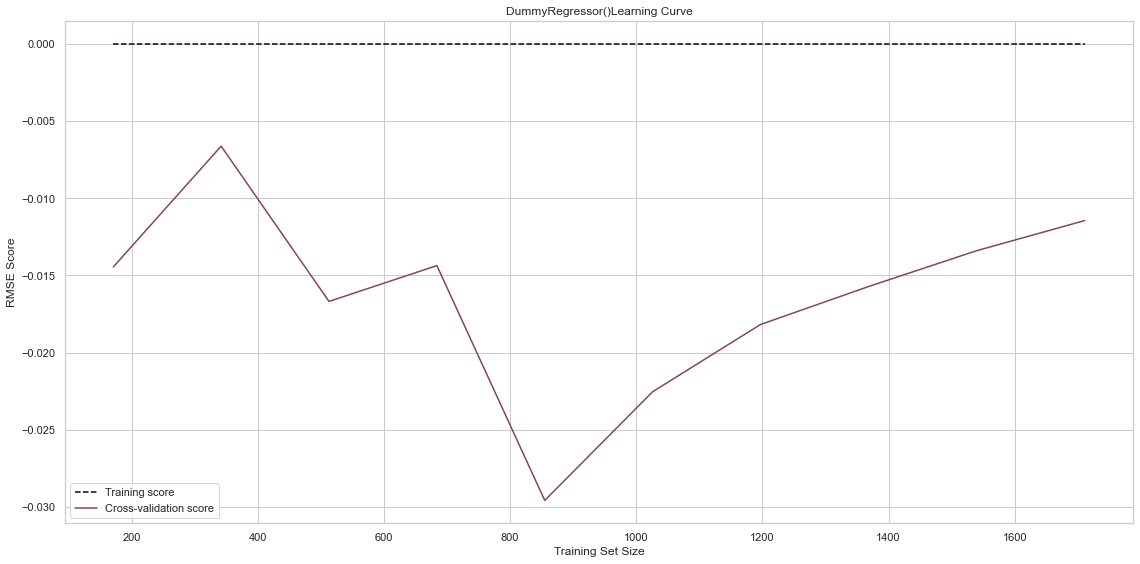

DummyRegressor(strategy='median') -0.08519628613284036


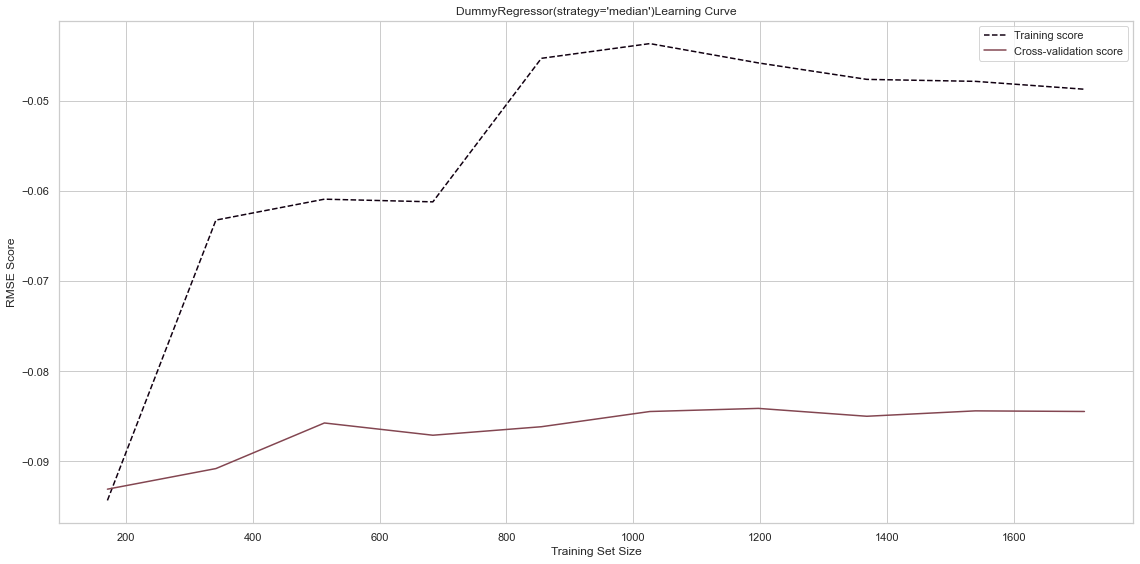

LinearRegression() 0.7178112233191809


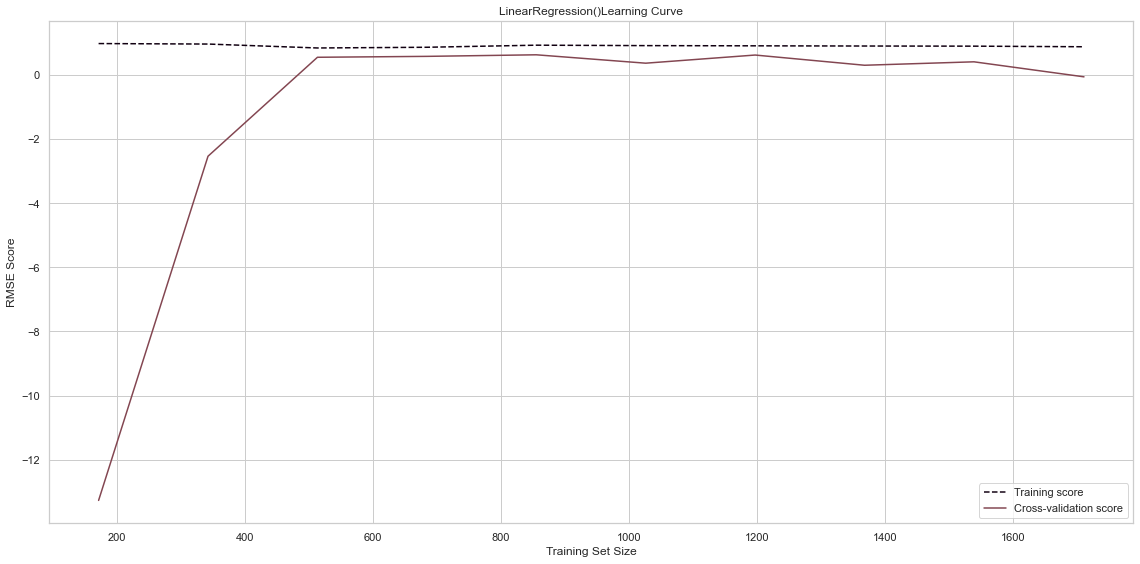

Lasso() 0.717811201677104


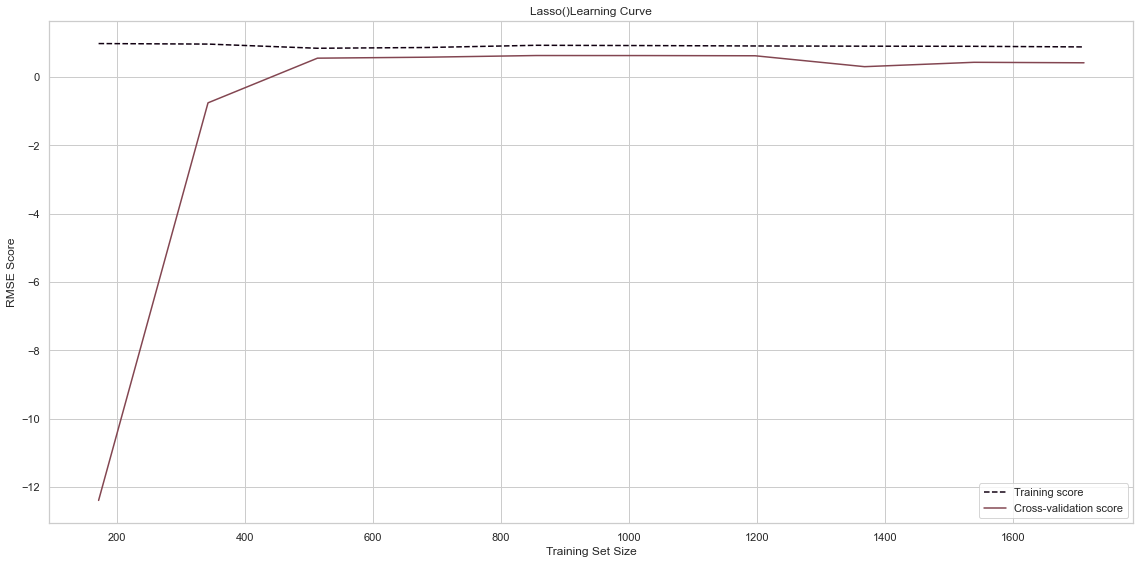

Ridge() 0.7177765296345654


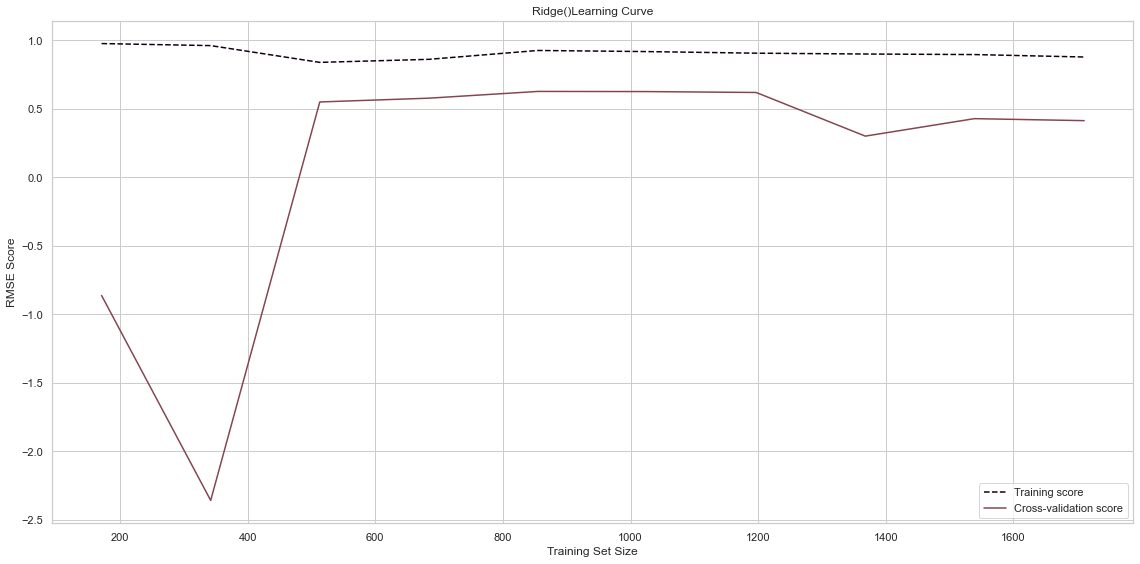

ElasticNet() 0.7167940645620986


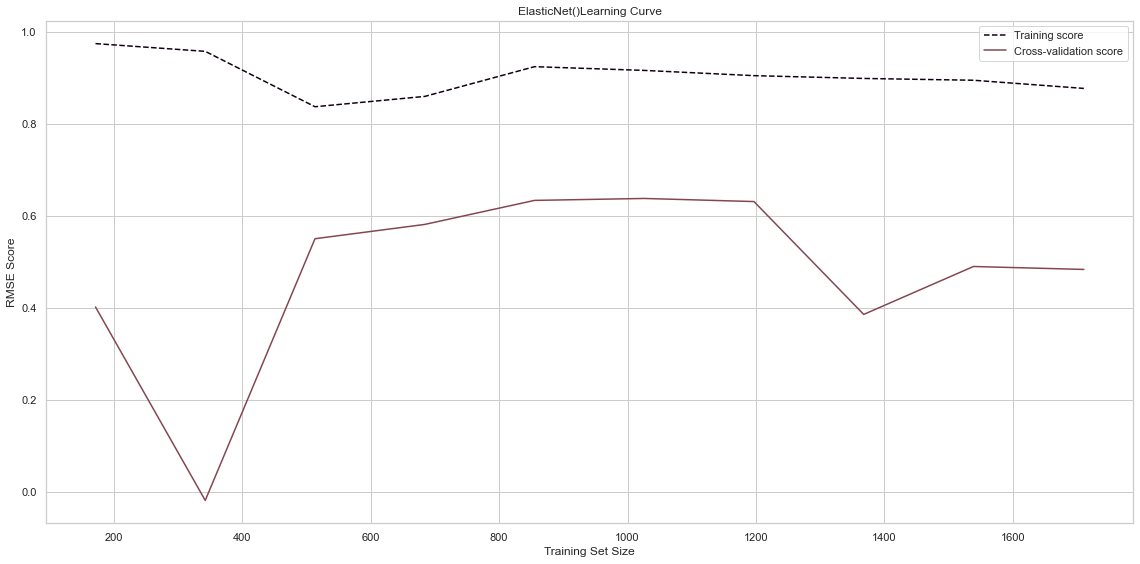

GradientBoostingRegressor() 0.9797415937132925


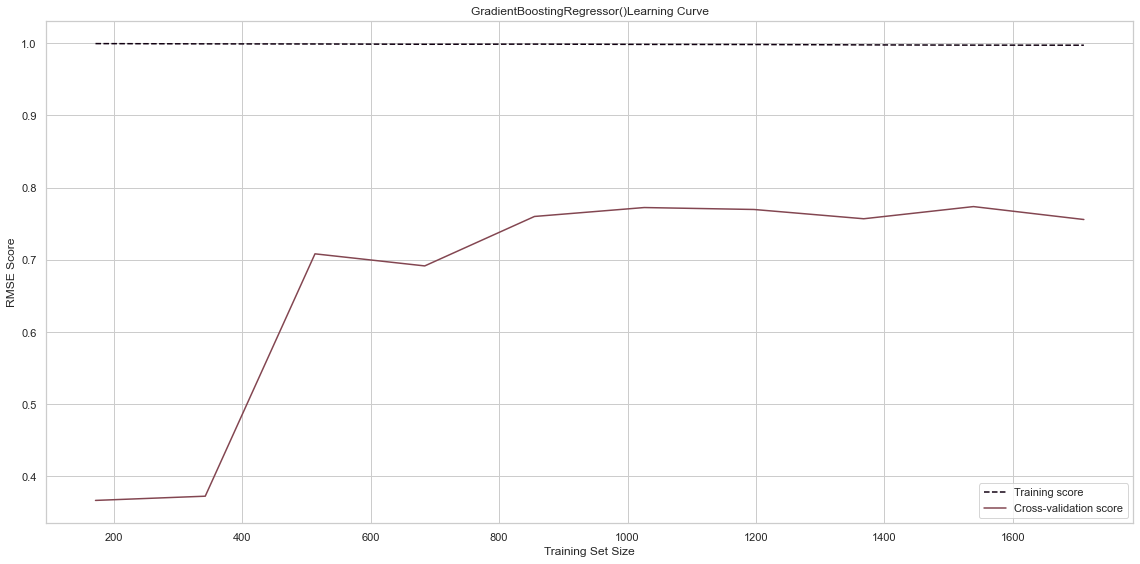

RandomForestRegressor() 0.9376302296068236


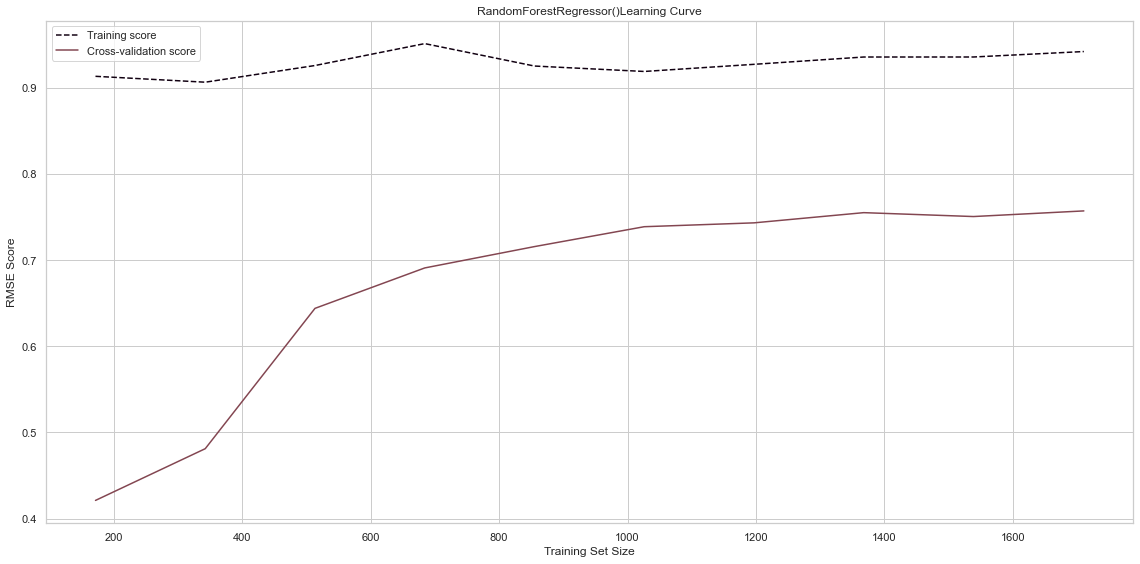

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 0.9396917032308025


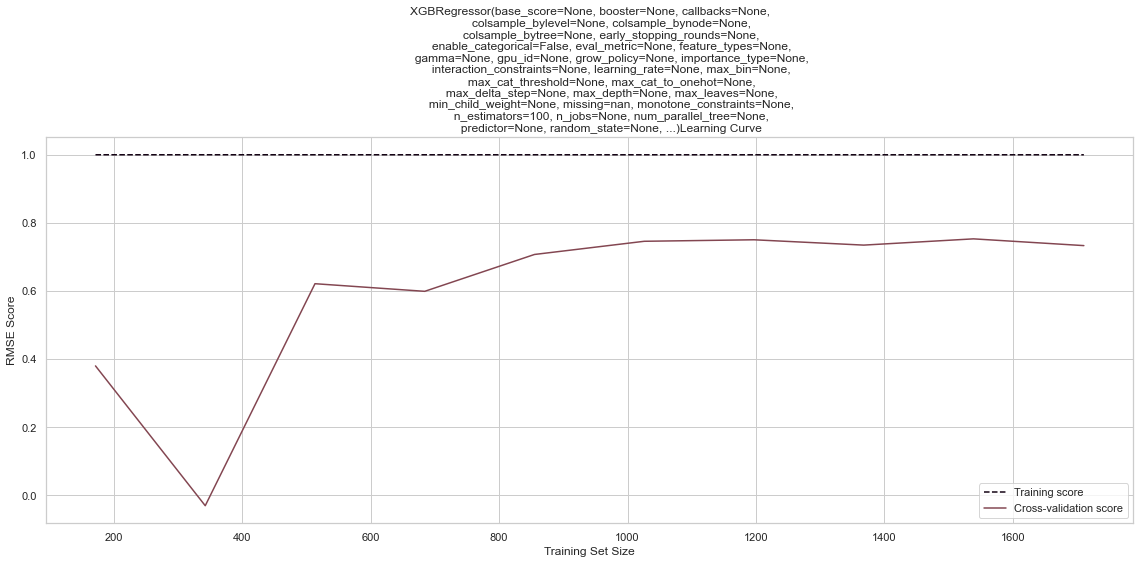

In [44]:
for model in list_of_models:
    evaluation(model)
    

* Mean Absolute Error (MAE) : C'est une mesure de la différence absolue entre les valeurs prédites et les valeurs réelles. Il est souvent utilisé lorsque les erreurs sont de même importance, quel que soit leur signe (positive ou négative). Il est facile à comprendre car il est exprimé dans les mêmes unités que les données d'entrée. Par exemple, si vous prévoyez le prix des maisons et que le MAE est de $50,000, cela signifie que la prévision est en moyenne à $50,000 de l'erreur de la valeur réelle.

* R-Squared : C'est un mesure de l'ajustement du modèle. Il varie entre 0 et 1, avec des valeurs proches de 1 indiquant un meilleur ajustement. Il est souvent utilisé pour montrer la proportion de la variance des données expliquée par le modèle. Par exemple, si vous prévoyez le prix des maisons et que le R-Squared est de 0.8, cela signifie que 80% de la variance des données est expliquée par le modèle.


# Optimisation
sans Energystarscore

## DummyRegressor

### strategy='mean'

In [45]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -4.291499922248754e-05


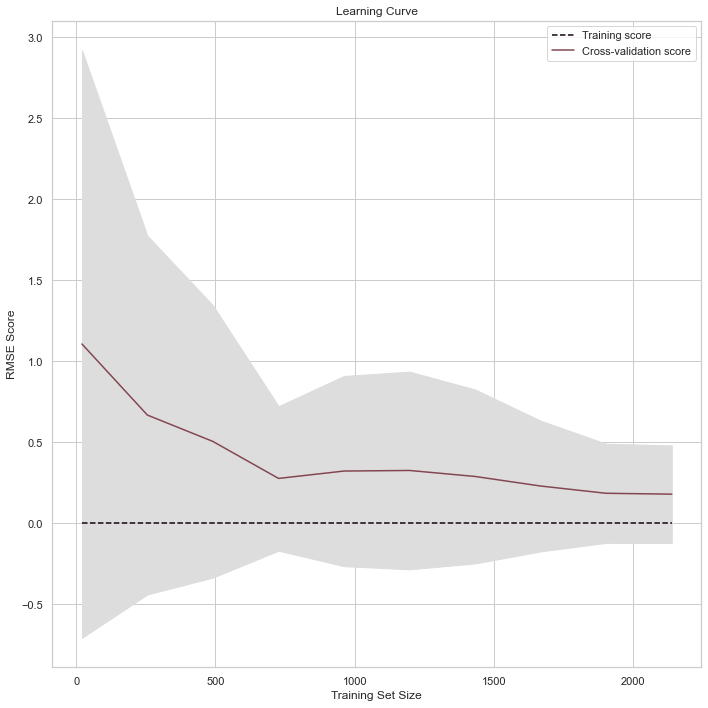

In [46]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)


# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

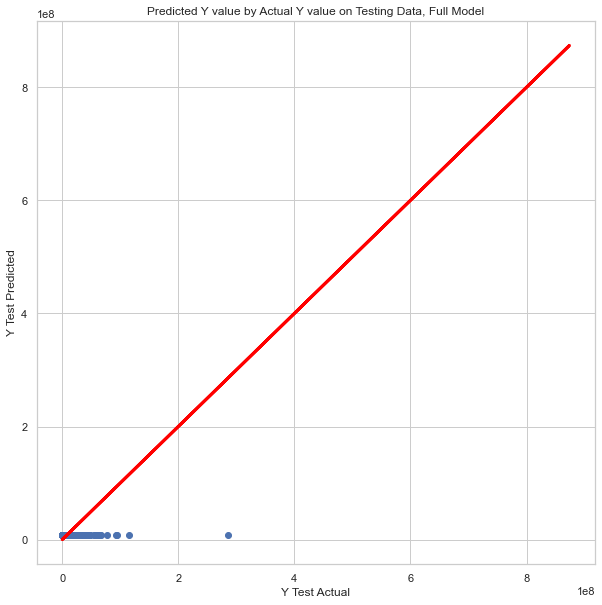

In [47]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


### strategy='median'

In [48]:
# Initialisation et entraînement du modèle
dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = dummy_regr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  -0.08519628613284036


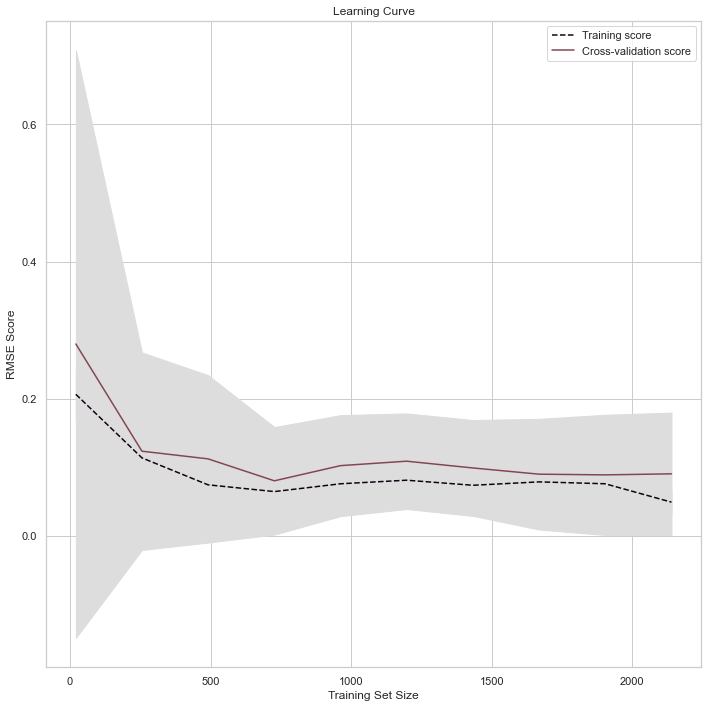

In [49]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(dummy_regr, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = -0.046896556365931374


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

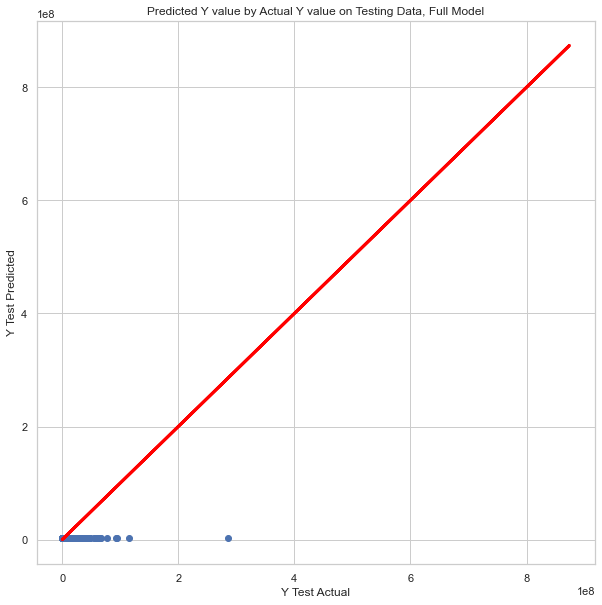

In [50]:
print('Coeff R2 =', dummy_regr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, dummy_regr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


### Cross-Validation 

La cross-validation est une technique utilisée dans l'apprentissage automatique pour évaluer la performance d'un modèle. Il permet de mesurer la capacité de généralisation d'un modèle, c'est-à-dire sa capacité à prédire de manière efficace sur des données qu'il n'a pas encore vues.

Il existe plusieurs techniques de validation croisée, mais la plus courante est la validation croisée K-fold. Cela consiste à diviser les données en K parties égales, appelées "volets", et à utiliser K-1 volets pour entraîner le modèle et un seul volet pour l'évaluer. Ce processus est répété K fois, en utilisant chaque volet comme volet de test une fois. Les résultats de chaque itération sont ensuite combinés pour obtenir une estimation de la performance globale du modèle.

La cross-validation est particulièrement utile lorsque les données sont limitées, car elle permet d'utiliser toutes les données disponibles pour l'entraînement et l'évaluation du modèle, ce qui réduit les biais dans l'évaluation de la performance. C'est aussi une technique très utilisée pour sélectionner les hyperparamètres d'un modèle, c'est-à-dire les paramètres qui ne sont pas appris directement à partir des données, mais qui sont définis avant l'entraînement.

In [51]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [52]:
kfold_validation=KFold(10)

In [53]:
results=cross_val_score(dummy_regr,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[-3.24160797e-01 -1.07725054e-01 -1.48272378e-03 -2.58837868e-03
 -6.61757386e-02 -3.45594133e-01 -1.02093802e-01 -1.48472350e-03
 -2.61390216e-04 -1.09081079e-02]
-0.09624748489285331


## Regression Linéaire

In [54]:
# Initialisation et entraînement du modèle
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = lr.predict(X_test)

# Évaluation des performances
r2 = r2_score(y_test, y_pred)
print("R^2: ", r2)

R^2:  0.7178112233191809


In [55]:
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [56]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [57]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

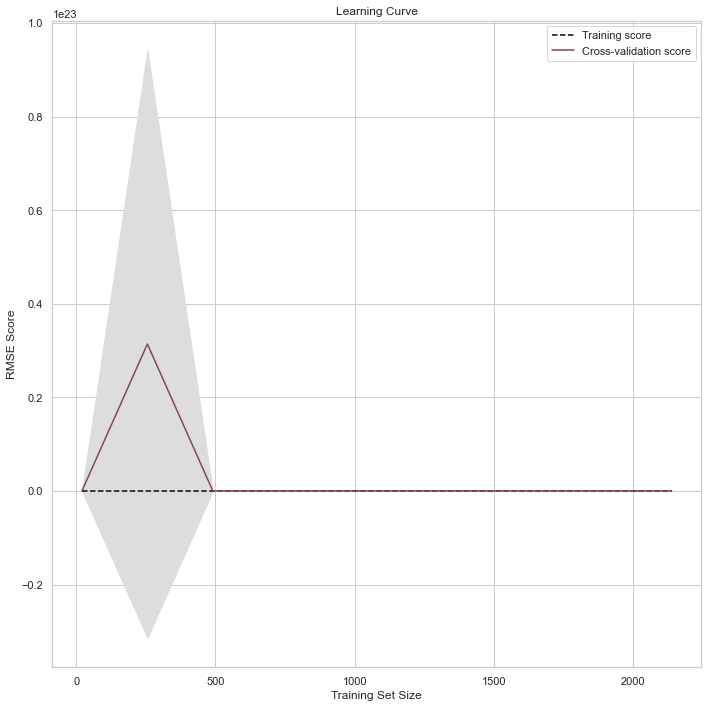

In [58]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.8810524547908181


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

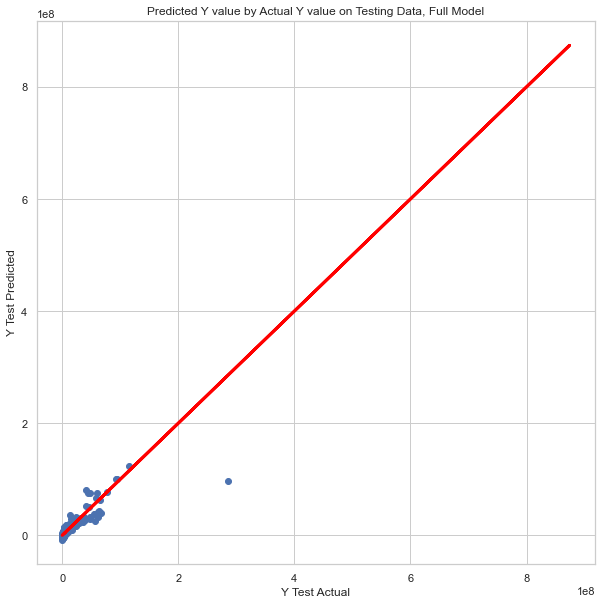

In [59]:
print('Coeff R2 =', lr.score(X,y))
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, lr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")


In [60]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

90300149586737.61


### Cross-Validation 

In [61]:
results=cross_val_score(lr,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[0.49350305 0.73476536 0.15879345 0.52452585 0.50449967 0.67248612
 0.78857486 0.7779173  0.52733824 0.96076656]
0.6143170465164854


## Lasso

In [62]:
las = Lasso()
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = las.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9004647517143543
0.717811201677104


In [63]:
train_sizes, train_scores, test_scores = learning_curve(Lasso(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [64]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [65]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

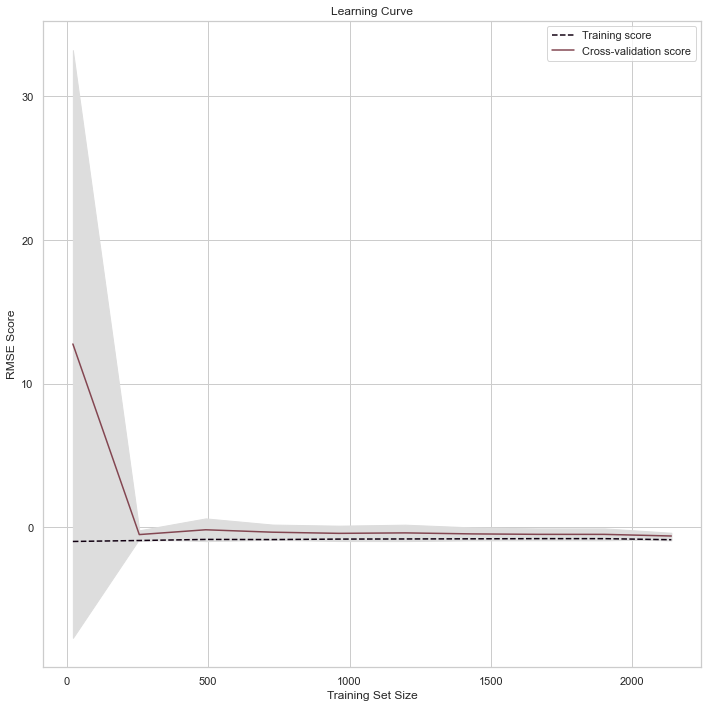

In [66]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

Coeff R2 = 0.8810524524868962


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

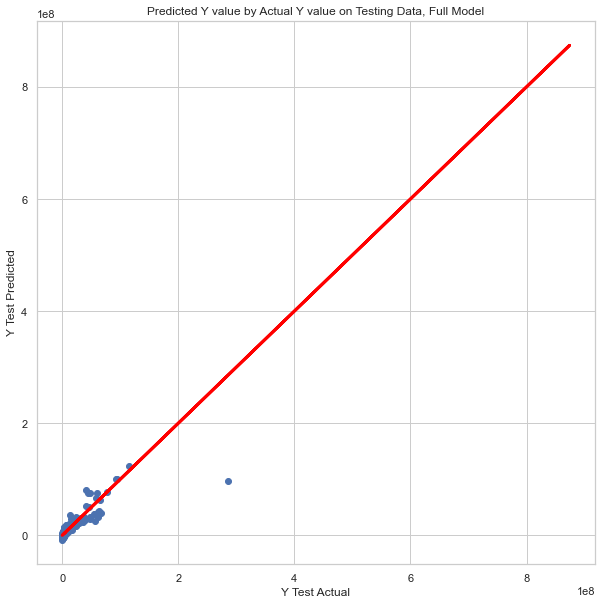

In [67]:
print('Coeff R2 =', las.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

In [68]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(), param_grid={'alpha': range(0, 1001, 50)},
             return_train_score=True, scoring='r2', verbose=1)

In [69]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.088761,0.005571,0.002892,0.000698,0.0,{'alpha': 0},0.928017,0.639486,0.646813,0.567880,0.679218,0.776843,0.551921,0.920763,0.640078,0.892268,0.724329,0.136959,21,0.897401,0.904102,0.92747,0.914237,0.912321,0.902854,0.906334,0.79452,0.905518,0.899857,0.896462,0.034946
1,0.051764,0.014619,0.003187,0.001075,50.0,{'alpha': 50},0.928019,0.639495,0.646813,0.567885,0.679207,0.776863,0.551950,0.920780,0.640092,0.892262,0.724337,0.136956,20,0.897401,0.904102,0.92747,0.914237,0.912321,0.902854,0.906334,0.79452,0.905518,0.899857,0.896462,0.034946
2,0.046474,0.010717,0.003292,0.001185,100.0,{'alpha': 100},0.928020,0.639504,0.646813,0.567890,0.679195,0.776883,0.551978,0.920798,0.640107,0.892256,0.724344,0.136954,19,0.897401,0.904102,0.92747,0.914237,0.912321,0.902854,0.906334,0.79452,0.905518,0.899857,0.896462,0.034946
3,0.047272,0.015821,0.003291,0.001266,150.0,{'alpha': 150},0.928022,0.639513,0.646813,0.567895,0.679182,0.776903,0.552007,0.920815,0.640121,0.892251,0.724352,0.136952,18,0.897401,0.904102,0.92747,0.914237,0.912321,0.902854,0.906334,0.79452,0.905518,0.899857,0.896461,0.034946
4,0.047071,0.013803,0.002997,0.000897,200.0,{'alpha': 200},0.928024,0.639522,0.646813,0.567899,0.679169,0.776923,0.552035,0.920833,0.640136,0.892245,0.724360,0.136949,17,0.897401,0.904102,0.92747,0.914237,0.912321,0.902854,0.906334,0.79452,0.905518,0.899856,0.896461,0.034946


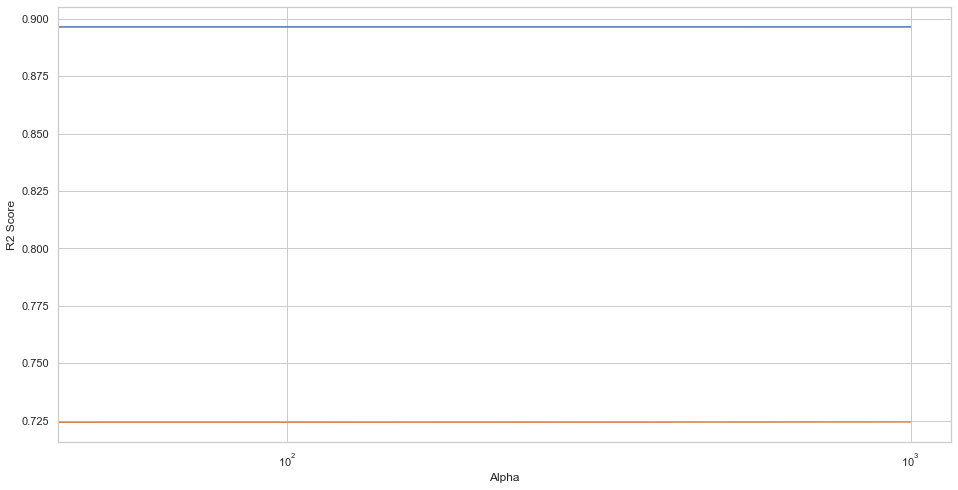

In [70]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [71]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 1000}

In [72]:
las = Lasso(alpha=0)
las.fit(X_train,y_train)

y_train_pred = las.predict(X_train)
y_test_pred = las.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9004647517185758
0.7178112233250277


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

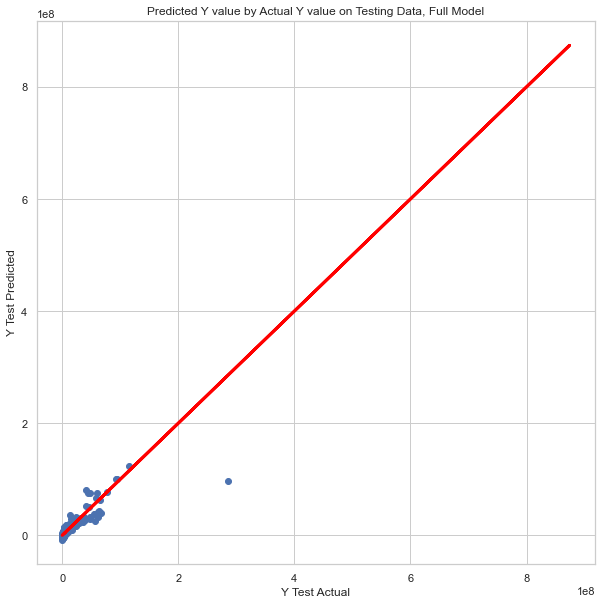

In [73]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, las.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

### Cross-Validation 

In [74]:
results=cross_val_score(las,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[0.49352606 0.73476536 0.15879345 0.52452585 0.50449967 0.67248612
 0.78857486 0.7779173  0.52733824 0.96076656]
0.6143193471128651


## Ridge

In [75]:
rid = Ridge()
rid.fit(X_train,y_train)

y_train_pred = rid.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = rid.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9004485703472116
0.7177765296345654


In [76]:
train_sizes, train_scores, test_scores = learning_curve(Ridge(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

In [77]:
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

In [78]:
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

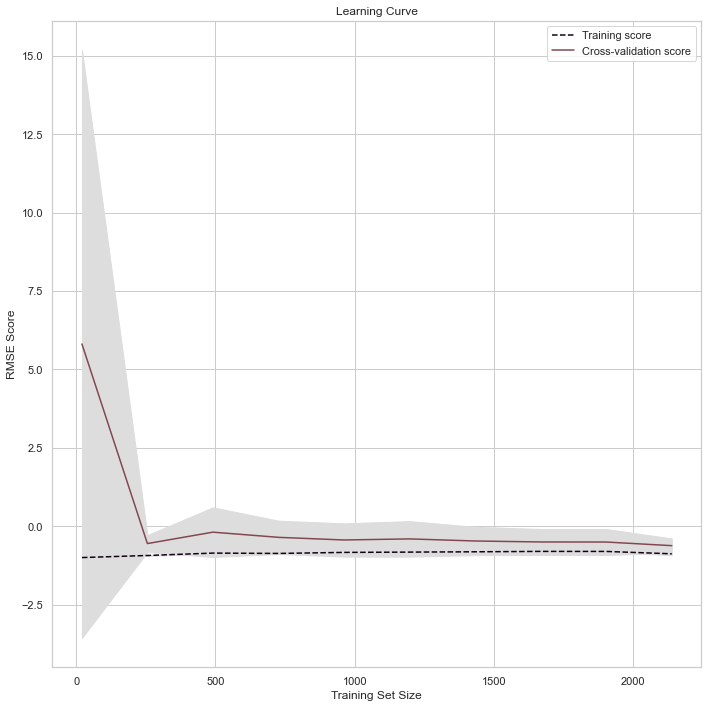

In [79]:
# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [80]:
rid = Ridge(alpha=0.001)
rid.fit(X_train,y_train)

y_train_pred = rid.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = rid.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.9004647516588258
0.7178112365578264


Coeff R2 = 0.8810524561444392


Text(0.5, 1.0, 'Predicted Y value by Actual Y value on Testing Data, Full Model')

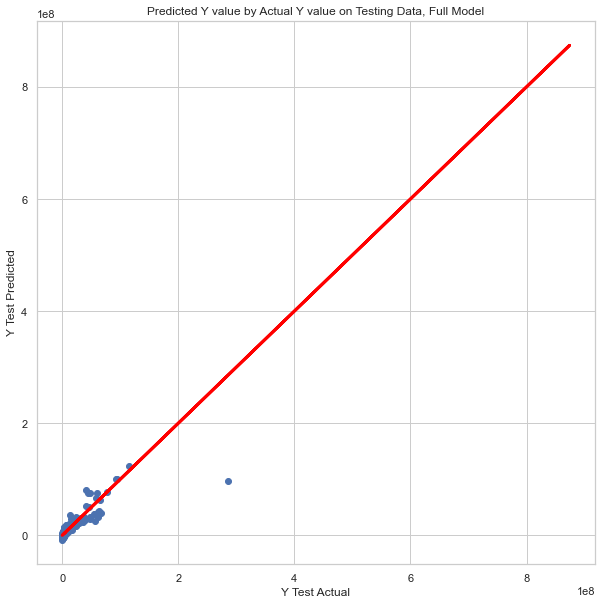

In [81]:
print('Coeff R2 =', rid.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rid.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

In [82]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(), param_grid={'alpha': range(0, 1001, 50)},
             return_train_score=True, scoring='r2', verbose=1)

In [83]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.009374,0.004117,0.003989,0.001411,0.0,{'alpha': 0},0.927463,0.639486,0.646813,0.565797,0.679218,0.777726,0.552368,0.920759,0.640078,0.889998,0.723971,0.136817,21,0.897297,0.904102,0.927470,0.914223,0.912321,0.902855,0.906297,0.794520,0.905518,0.899771,0.896438,0.034943
1,0.007182,0.002884,0.003688,0.001185,50.0,{'alpha': 50},0.927971,0.640381,0.646673,0.567966,0.679191,0.778206,0.554902,0.922351,0.640911,0.891689,0.725024,0.136682,20,0.897336,0.904021,0.927404,0.914170,0.912308,0.902763,0.906233,0.794377,0.905446,0.899817,0.896387,0.034969
2,0.006882,0.001863,0.003889,0.001372,100.0,{'alpha': 100},0.928014,0.640442,0.646595,0.568007,0.679781,0.778192,0.555820,0.923512,0.641223,0.891562,0.725315,0.136683,19,0.897334,0.904019,0.927403,0.914168,0.912307,0.902761,0.906231,0.794373,0.905444,0.899816,0.896385,0.034970
3,0.004788,0.000977,0.002791,0.000870,150.0,{'alpha': 150},0.928055,0.640497,0.646517,0.568044,0.680365,0.778172,0.556724,0.924637,0.641526,0.891437,0.725597,0.136683,18,0.897333,0.904017,0.927402,0.914167,0.912305,0.902760,0.906230,0.794371,0.905442,0.899815,0.896384,0.034970
4,0.007480,0.001428,0.004388,0.001017,200.0,{'alpha': 200},0.928094,0.640550,0.646440,0.568079,0.680938,0.778151,0.557621,0.925731,0.641825,0.891312,0.725874,0.136682,17,0.897331,0.904016,0.927401,0.914166,0.912304,0.902759,0.906228,0.794368,0.905441,0.899814,0.896383,0.034971


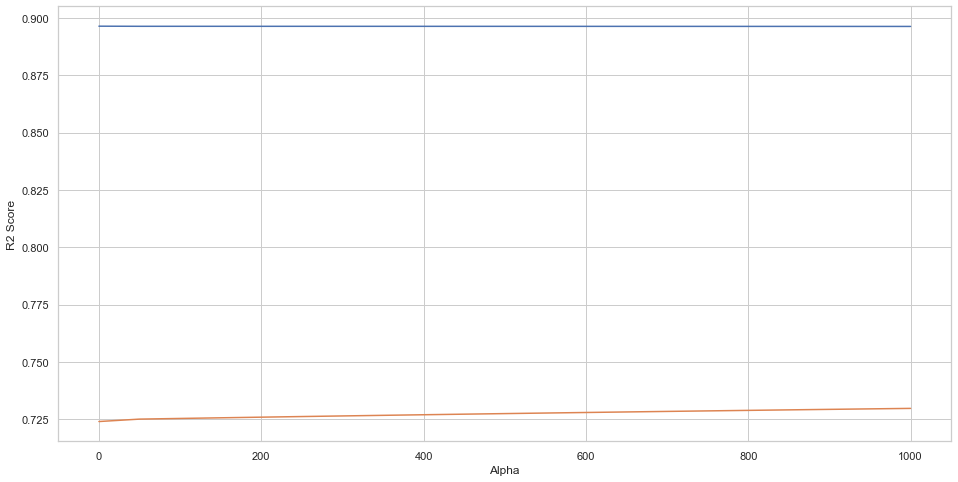

In [84]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [85]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 1000}

In [86]:
rid = Ridge(alpha = 100)
rid.fit(X_train,y_train)

y_pred_train = rid.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = rid.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.9003955494406243
0.7175714995547368


In [87]:
model_parameter = list(rid.coef_)
model_parameter.insert(0,rid.intercept_)
cols = df_pred_energy.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

NameError: name 'df_pred_energy' is not defined

In [ ]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

In [ ]:
print('Coeff R2 =', rid.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rid.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

### Cross-Validation 

In [ ]:
results=cross_val_score(rid,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

## ElasticNet

In [ ]:
elastic = ElasticNet()
elastic.fit(X_train,y_train)

y_train_pred = elastic.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = elastic.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(ElasticNet(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [ ]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':range(0, 1001, 50)}

model = ElasticNet()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

In [ ]:
cv_result_e = pd.DataFrame(model_cv.cv_results_)
cv_result_e['param_alpha'] = cv_result_e['param_alpha'].astype('float32')
cv_result_e.head()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_e['param_alpha'],cv_result_e['mean_train_score'])
plt.plot(cv_result_e['param_alpha'],cv_result_e['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [ ]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

In [ ]:
elastic = ElasticNet(alpha = 0)
elastic.fit(X_train,y_train)

y_pred_train = elastic.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = elastic.predict(X_test)
print(r2_score(y_test,y_pred_test))

In [ ]:
print('Coeff R2 =', elastic.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, elastic.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## GradientBoostingRegressor

In [ ]:
GB = GradientBoostingRegressor()
GB.fit(X_train,y_train)

y_train_pred = GB.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = GB.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
# Définir les tailles d'échantillon pour la courbe d'apprentissage
train_sizes = np.linspace(0.01, 1, 10)

# Calculer les scores pour chaque taille d'échantillon
train_sizes, train_scores, test_scores = learning_curve(GradientBoostingRegressor(), X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculer les moyennes et les écarts-types des scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Drawing lines
plt.subplots(1, figsize=(10,10) )
plt.plot(train_sizes, train_mean, '--', color="#110011",  label="Training score")
plt.plot(train_sizes, test_mean, color="#834651", label="Cross-validation score")

# Drawing bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Creating plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE Score"), plt.legend(loc="best")
plt.tight_layout();
plt.show()

In [ ]:
#folds  = KFold(n_splits=10,shuffle=True,random_state=42)

#hyper_param = {'n_estimators':range(80), 
#                  'max_depth':[14],
#                  'min_samples_split':[100],
#                  'max_features':[10],
#                  'subsample':[1]}


#model = GradientBoostingRegressor()

#model_cv = GridSearchCV(estimator=model,
#                        param_grid=hyper_param,
#                        scoring='r2',
#                        cv=folds,
#                        verbose=1,
#                        return_train_score=True)

#model_cv.fit(X_train,y_train)

In [ ]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r

In [ ]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

In [ ]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'n_estimators':[80], 
                  'max_depth':[14],
                  'min_samples_split':[100],
                  'max_features':[10],
                  'subsample':[1]}


model = GradientBoostingRegressor()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

In [ ]:
y_train_pred = model_cv.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = model_cv.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

In [ ]:
print('Coeff R2 =', GB.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, GB.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## RandomForestRegressor
Les hyperparamètres courants pour un RandomForestRegressor sont les suivants:

* n_estimators: nombre d'arbres de décision dans la forêt.
* criterion: fonction de coût utilisée pour mesurer la qualité de chaque séparation.
* max_depth: profondeur maximale de chaque arbre.
* min_samples_split: nombre minimum d'échantillons nécessaires pour diviser un noeud.
* min_samples_leaf: nombre minimum d'échantillons requis pour être un noeud feuille.
* min_weight_fraction_leaf: fraction minimale du poids total d'échantillons requis pour être un noeud feuille.
* max_features: nombre maximum de caractéristiques considérées lors de la recherche d'une meilleure séparation.
* max_leaf_nodes: nombre maximal de noeuds feuilles dans chaque arbre.
* min_impurity_decrease: réduit minimale de l'impureté pour diviser un noeud.



In [ ]:
# With no clear pattern detected, let's fit a random forest and check for feature importances.
rfr = RandomForestRegressor(n_estimators = 80, criterion = 'mse', random_state= 8, oob_score  = True)
rfr.fit(X_train, y_train)

In [ ]:
print(rfr.oob_score_)
# This is the R_squared on out-of-bag training data.

In [ ]:
#np.mean((rfr.predict(X_test) - y_test)**2)
# This is the RSE on testing data.
# Given the magnitude of the response variable y, this is actually pretty impressive!

In [ ]:
print('Coeff R2 =', rfr.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, rfr.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

## XGBRegressor

In [ ]:
XGB = XGBRegressor()

In [ ]:
XGB = XGBRegressor(n_estimators=1000, learning_rate=0.1)
XGB.fit(X_train, y_train, early_stopping_rounds=26, 
             eval_set=[(X_test, y_test)], verbose=False)

In [ ]:
print('Coeff R2 =', XGB.score(X,y))
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(y_train, y_train, c='red', lw=3)
ax.scatter(y_test, XGB.predict(X_test))
ax.set_xlabel('Y Test Actual')
ax.set_ylabel('Y Test Predicted')
ax.set_title("Predicted Y value by Actual Y value on Testing Data, Full Model")

# Model vs ENERGYSTARScore 